In [1]:
import cv2 as cv
import keras
import keras.applications as apps
import numpy as np
import os
import densenet
import glob

import tqdm
import matplotlib.pyplot as plt
import matplotlib
import random
plt.ion()

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/paperspace/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [10]:
TILE_SIZE = 221

In [3]:
net = densenet.DenseNet121(include_top=True,
                      weights=None,
                      input_shape=(221, 221, 2),
                      pooling=None,
                      classes=1)

/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/applications/imagenet_utils.py:258: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  str(input_shape[-1]) + ' input channels.')


In [4]:
def tile_image(HH, HV, conc, tile_size=221):
    # This function assumes all images are the same shape
    tile_center = tile_size//2
    amount_x = (HH.shape[0]//tile_size) -1
    amount_y = (HH.shape[1]//tile_size) -1
    sar_tiles = []
    conc_tiles = []
    for i in range(amount_x):
        for j in range(amount_y):
            x_bounds = [tile_size*i, tile_size*(i+1)]
            y_bounds = [tile_size*j, tile_size*(j+1)]
            conc_tile = conc[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]]
            if np.max(conc_tile) != 255:
                HH_tile = HH[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]]
                HV_tile = HV[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]]
                tile = np.stack([HH_tile, HV_tile],axis=-1)
                sar_tiles.append(tile)
                conc_tiles.append([conc_tile[tile_center, tile_center]])
    sar_tiles = np.asarray(sar_tiles).astype(np.float32)/255
    conc_tiles = np.asarray(conc_tiles).astype(np.float32)/100
    
    return sar_tiles, conc_tiles

In [5]:
# Utility methods to process/load images
def is_data_valid(folder_path):
    valid = os.path.exists(os.path.join(folder_path, 'imagery_HH.tif'))
    valid = valid and os.path.exists(os.path.join(folder_path, 'imagery_HV.tif')) 
    valid = valid and os.path.exists(os.path.join(folder_path, 'conc.tiff'))
    return valid

def read_data(folder):
    hh_image = cv.imread(os.path.join(folder, 'imagery_HH.tif'), cv.IMREAD_GRAYSCALE)
    hv_image = cv.imread(os.path.join(folder, 'imagery_HV.tif'), cv.IMREAD_GRAYSCALE)
    conc_image = cv.imread(os.path.join(folder, 'conc.tiff'), cv.IMREAD_GRAYSCALE)
    if conc_image is None:
        conc_image = np.ones(hh_image.shape)
    return hh_image, hv_image, conc_image

def tile_image(HH, HV, conc, tile_size=221):
    # This function assumes all images are the same shape
    tile_center = tile_size//2
    amount_x = (HH.shape[0]//tile_size) -1
    amount_y = (HH.shape[1]//tile_size) -1
    sar_tiles = []
    conc_tiles = []
    for i in range(amount_x):
        for j in range(amount_y):
            x_bounds = [tile_size*i, tile_size*(i+1)]
            y_bounds = [tile_size*j, tile_size*(j+1)]
            conc_tile = conc[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]]
            # check if the center of the tile is land or not
            if conc_tile[tile_center, tile_center] != 255:
                # set all values within the SAR image to by 255 if that part of the image is land
                HH_tile = np.where(conc_tile == 255,255,HH[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]])
                HV_tile = np.where(conc_tile == 255, 255, HV[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]])
                tile = np.stack([HH_tile, HV_tile],axis=-1)
                sar_tiles.append(tile)
                conc_tiles.append([conc_tile[tile_center, tile_center]])
    sar_tiles = np.asarray(sar_tiles).astype(np.float32)/255
    conc_tiles = np.asarray(conc_tiles).astype(np.float32)/100
    
    return sar_tiles, conc_tiles

def gen_tile_data(folder_name, images, labels, pos, dry_run=False, multiplier=1):
    amount = 0
    try:
        SHIFT = TILE_SIZE//multiplier
        hh_image, hv_image, conc_image = read_data(folder_name)
        conc_image_big = cv.resize(conc_image, hh_image.shape[0:2][::-1])
        for _ in range(multiplier):
            hh_image = hh_image[SHIFT:, SHIFT:]
            hv_image = hv_image[SHIFT:, SHIFT:]
            conc_image_big = conc_image_big[SHIFT:, SHIFT:]
            im_tiles, c_tiles = tile_image(hh_image, hv_image, conc_image_big)
            if not dry_run:
                images[pos+amount:pos + amount+ len(im_tiles)] = im_tiles
                labels[pos+amount:pos + amount + len(c_tiles)] = c_tiles
            amount = amount + len(im_tiles)
    except:
        print(folder_name)
    if dry_run:
        return amount
    return images, labels, pos + amount

In [6]:
def predict_image_fine(HH, HV, conc, model,scan_size=3, tile_size=221):
#     Decimate
#     HH = cv.resize(HH, None, fx=0.5,fy=0.5)
#     HV = cv.resize(HV, None, fx=0.5,fy=0.5)
#     conc = cv.resize(conc, None, fx=0.5,fy=0.5)
    amount_x = ((HH.shape[0])//tile_size) -2
    amount_y = (HH.shape[1]//tile_size) -2
    tile_center = tile_size//2

#     sar_tiles = []
    conc_image = np.ones((amount_x*(scan_size+1), amount_y*(scan_size+1)))*255
    sar_amount = 0
    for i in (range(amount_x)):
        for j in range(amount_y):
            for s in range(scan_size+1):
                for x in range(scan_size+1):
                    x_bounds = [int(tile_size*(i+ s/scan_size)), int(tile_size*(i+1 + s/scan_size))]
                    y_bounds = [int(tile_size*(j + x/scan_size)), int(tile_size*(j+1 + x/scan_size))]
                    conc_tile = conc[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]]
                    if conc_tile[tile_center, tile_center] < 255:
                        sar_amount += 1
    print(sar_amount)
    sar_arr = np.zeros((sar_amount, tile_size, tile_size, 2), dtype=np.float16)
    
    sar_count = 0
    for i in (range(amount_x)):
        for j in range(amount_y):
            for s in range(scan_size+1):
                for x in range(scan_size+1):
                    x_bounds = [int(tile_size*(i+ s/scan_size)), int(tile_size*(i+1 + s/scan_size))]
                    y_bounds = [int(tile_size*(j + x/scan_size)), int(tile_size*(j+1 + x/scan_size))]
                    conc_tile = conc[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]]
                    if conc_tile[tile_center, tile_center] < 255:
                        HH_tile = np.where(conc_tile == 255, 255,HH[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]])
                        HV_tile = np.where(conc_tile == 255, 255, HV[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]])
                        tile =np.stack([HH_tile, HV_tile],axis=-1)
                        tile = tile.astype(np.float16)/255
#                         sar_tiles.append(tile)
                        sar_arr[sar_count] = tile
                        sar_count += 1

#                         pred = model.predict(tile)
#                         pval = pred.flatten()[0]
#                         if pval > 1.5:
#                             pval = np.nan
#         #                 print('VAL:', pred)
# #                         conc_image[i,j] = pval
#                         conc_image[i*(scan_size+1)+s,j*(scan_size+1) + x] = pval
#                     else:
#                         conc_image[i*(scan_size+1)+s,j*(scan_size+1) + x] = np.nan
    preds = model.predict(sar_arr)
    p_ind = 0
    for i in (range(amount_x)):
            for j in range(amount_y):
                for s in range(scan_size+1):
                    for x in range(scan_size+1):
                        x_bounds = [int(tile_size*(i+ s/scan_size)), int(tile_size*(i+1 + s/scan_size))]
                        y_bounds = [int(tile_size*(j + x/scan_size)), int(tile_size*(j+1 + x/scan_size))]
                        conc_tile = conc[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]]
                        if conc_tile[tile_center, tile_center] < 255:
                            pval = preds[p_ind]
                            p_ind = p_ind + 1
                            if pval > 1.5:
                                pval = np.nan
#                             elif pval < 0.1:
#                                 pval = np.nan
            #                 print('VAL:', pred)
#                             conc_image[i,j] = pval
                            conc_image[i*(scan_size+1)+s,j*(scan_size+1) + x] = pval
                        else:
                            conc_image[i*(scan_size+1)+s,j*(scan_size+1) + x] = np.nan
#     conc_image = cv.resize(conc_image, None, fx=2, fy=2)
    return conc_image

In [7]:
def is_data_valid(folder_path):
    valid = os.path.exists(os.path.join(folder_path, 'imagery_HH.tif'))
    valid = valid and os.path.exists(os.path.join(folder_path, 'imagery_HV.tif')) 
#     valid = valid and os.path.exists(os.path.join(folder_path, 'conc.tiff'))
    return valid
    

In [8]:
def read_data(folder):
    hh_image = cv.imread(os.path.join(folder, 'imagery_HH.tif'), cv.IMREAD_GRAYSCALE)
    hv_image = cv.imread(os.path.join(folder, 'imagery_HV.tif'), cv.IMREAD_GRAYSCALE)
    conc_image = cv.imread(os.path.join(folder, 'conc.tiff'), cv.IMREAD_GRAYSCALE)
    return hh_image, hv_image, conc_image

In [9]:
folders = [f for f in glob.glob(os.path.join('lab_sea/2013_data/lab_sea/2013_data','RS2*')) if is_data_valid(f)]

In [10]:
folders = [f for f in glob.glob(os.path.join('training_data', '20*')) if is_data_valid(f)]

In [11]:
folders

['training_data/20110705',
 'training_data/20110405',
 'training_data/20110717C',
 'training_data/20110216',
 'training_data/20101007',
 'training_data/20110220',
 'training_data/20100131',
 'training_data/20110319',
 'training_data/20110717',
 'training_data/20100405',
 'training_data/20110717B',
 'training_data/20101213',
 'training_data/20110903',
 'training_data/20110903B',
 'training_data/20110903C',
 'training_data/20110213',
 'training_data/20110702',
 'training_data/20101221',
 'training_data/20110223',
 'training_data/20101009B',
 'training_data/20101205',
 'training_data/20101013',
 'training_data/20110214',
 'training_data/20110217',
 'training_data/20101009',
 'training_data/20110903D',
 'training_data/20100403',
 'training_data/20110730']

In [10]:
q = os.path.join('lab_sea/2013_data/images_gsl2014', os.listdir('lab_sea/2013_data/images_gsl2014')[0])

In [11]:
os.path.exists(os.path.join(q, 'imagery_HV.tif'))

True

In [12]:
is_data_valid(q)

True

In [12]:
masks = [os.path.basename(f) for f in glob.glob('masks/*.png')]

In [11]:
trails = ['weights/net_checkpoint_FINAL.hdf5']
for trial in trails:
    net.load_weights(trial)
    print("TRIAL:", trial)
    folders = [f for f in glob.glob(os.path.join('training_data', '20*')) if is_data_valid(f)]
    for stride in range(1, 4):
        results_folder = os.path.basename(trial)[:-5] + '_TRAIN_STRIDE_' + str(stride)
        print('RESULTS:', results_folder)
        os.makedirs(results_folder, exist_ok=True)
        for folder in tqdm.tqdm(folders[0:3]):
            try:
                image_name = os.path.basename(folder) + ".tiff"
                image_path = os.path.join(results_folder, 'bigger_' + image_name)
                if (not os.path.exists(image_path)):

                    hh_image, hv_image, conc_image = read_data(folder)
                    if conc_image is None:
                        mask = [f for f in masks if os.path.splitext(image_name)[0] in f][0]

                        print('USING MASK')
                        conc_image = cv.imread(os.path.join('masks',mask), cv.IMREAD_GRAYSCALE)
                    if conc_image is None:
                        print("BAAAD: ", folder)
                        continue
                #         conc_image_big = np.zeros(hh_image.shape)
                    conc_image_big = cv.resize(conc_image, hh_image.shape[0:2][::-1])
                    conc = predict_image_fine(hh_image, hv_image, conc_image_big, net, scan_size=stride)*200
                    image_name = os.path.basename(folder) + ".tiff"
                    mask_name = 'new_mask_' + image_name
                    image_path = os.path.join(results_folder, 'bigger_' + image_name)
                    mask_path = os.path.join(results_folder, mask_name)
                    cv.imwrite(image_path, conc)
                    new_mask  = np.isnan(conc).astype(np.uint8)*255
                    cv.imwrite(mask_path, new_mask)
                    plt.imshow(conc)
                else:
                    print("AD: " + image_name)
            except:
                print("BAD: ", folder)
    
#     results_folder = os.path.basename(trial)[:-5] + '_LAB'
#     print("RESULTS:", results_folder)
#     folders = [f for f in glob.glob(os.path.join('lab_sea/2013_data/lab_sea/2013_data','RS2*')) if is_data_valid(f)]
#     os.makedirs(results_folder, exist_ok=True)
#     for folder in tqdm.tqdm(folders):
#         try:
#             image_name = os.path.basename(folder) + ".tiff"
#             image_path = os.path.join(results_folder, 'bigger_' + image_name)
#             if (not os.path.exists(image_path)):
#                 hh_image, hv_image, conc_image = read_data(folder)
#                 if conc_image is None:
#                     mask = [f for f in masks if os.path.splitext(image_name)[0] in f][0]
#                     print('USING MASK')
#                     conc_image = cv.imread(os.path.join('masks',mask), cv.IMREAD_GRAYSCALE)
#                 if conc_image is None:
#                     print("BAAAD: ", folder)
#                     continue
#             #         conc_image_big = np.zeros(hh_image.shape)
#                 conc_image_big = cv.resize(conc_image, hh_image.shape[0:2][::-1])
#                 conc = predict_image_fine(hh_image, hv_image, conc_image_big, net)*200
#                 image_name = os.path.basename(folder) + ".tiff"
#                 mask_name = 'new_mask_' + image_name
#                 image_path = os.path.join(results_folder, 'bigger_' + image_name)
#                 mask_path = os.path.join(results_folder, mask_name)
#                 cv.imwrite(image_path, conc)
#                 new_mask  = np.isnan(conc).astype(np.uint8)*255
#                 cv.imwrite(mask_path, new_mask)
#                 plt.imshow(conc)
#             else:
#                 print("AD: " + image_name)
#         except:
#             print(folder)
#     results_folder = os.path.basename(trial)[:-5] + '_GSL'
#     folders = [f for f in glob.glob(os.path.join('lab_sea/2013_data/images_gsl2014','RS2*')) if is_data_valid(f)]
#     os.makedirs(results_folder, exist_ok=True)
#     print("RESULTS:", results_folder)
#     for folder in tqdm.tqdm(folders):
#         try:
#             image_name = os.path.basename(folder) + ".tiff"
#             image_path = os.path.join(results_folder, 'bigger_' + image_name)
#             if (not os.path.exists(image_path)):
#                 mask = [f for f in masks if os.path.splitext(image_name)[0] in f][0]

#                 hh_image, hv_image, conc_image = read_data(folder)
#                 conc_image = cv.imread(os.path.join('masks',mask), cv.IMREAD_GRAYSCALE)
#                 if conc_image is None:
#                     print("BAAAD: ", folder)
#                     continue
#             #         conc_image_big = np.zeros(hh_image.shape)
#                 conc_image_big = cv.resize(conc_image, hh_image.shape[0:2][::-1])
#                 conc = predict_image_fine(hh_image, hv_image, conc_image_big, net)*200
#                 image_name = os.path.basename(folder) + ".tiff"
#                 mask_name = 'new_mask_' + image_name
#                 image_path = os.path.join(results_folder, 'bigger_' + image_name)
#                 mask_path = os.path.join(results_folder, mask_name)
#                 cv.imwrite(image_path, conc)
#                 new_mask  = np.isnan(conc).astype(np.uint8)*255
#                 cv.imwrite(mask_path, new_mask)
#                 plt.imshow(conc)
#             else:
#                 print("AD: " + image_name)
#         except:
#             print(folder)

  0%|          | 0/3 [00:00<?, ?it/s]

TRIAL: weights/net_checkpoint_FINAL.hdf5
RESULTS: net_checkpoint_FINAL_TRAIN_STRIDE_1
AD: 20110705.tiff
AD: 20110405.tiff


  0%|          | 0/3 [00:00<?, ?it/s]

BAD:  training_data/20110717C
RESULTS: net_checkpoint_FINAL_TRAIN_STRIDE_2
AD: 20110705.tiff
AD: 20110405.tiff


  0%|          | 0/3 [00:00<?, ?it/s]

BAD:  training_data/20110717C
RESULTS: net_checkpoint_FINAL_TRAIN_STRIDE_3
AD: 20110705.tiff
AD: 20110405.tiff


100%|██████████| 3/3 [00:00<00:00,  5.97it/s]

BAD:  training_data/20110717C


In [30]:
net.load_weights('weights/net_checkpoint_AMORE_R4.hdf5')

In [31]:
results_folder = 'results_special_AMORE_R4_lab'
os.makedirs(results_folder, exist_ok=True)

  0%|          | 0/10 [00:00<?, ?it/s]

13813


 10%|█         | 1/10 [01:47<16:07, 107.48s/it]

21905


 20%|██        | 2/10 [04:35<18:22, 137.87s/it]

20399


 30%|███       | 3/10 [06:38<15:30, 132.86s/it]

lab_sea/2013_data/lab_sea/2013_data/RS2_OK44073_PK425836_DK376184_SCWA_20130913_150901_HH_HV_SGF
12686


 40%|████      | 4/10 [06:51<10:16, 102.81s/it]

lab_sea/2013_data/lab_sea/2013_data/RS2_OK44073_PK425834_DK376182_SCWA_20130913_132853_HH_HV_SGF


 50%|█████     | 5/10 [06:51<06:51, 82.33s/it] 

lab_sea/2013_data/lab_sea/2013_data/RS2_OK44067_PK425720_DK376088_SCWA_20130910_131728_HH_HV_SGF


 60%|██████    | 6/10 [06:52<04:34, 68.67s/it]

lab_sea/2013_data/lab_sea/2013_data/RS2_OK45827_PK443016_DK394472_SCWA_20131112_105716_HH_HV_SGF


 70%|███████   | 7/10 [06:52<02:56, 58.91s/it]

lab_sea/2013_data/lab_sea/2013_data/RS2_OK44073_PK425837_DK376185_SCWA_20130913_151015_HH_HV_SGF


 80%|████████  | 8/10 [06:52<01:43, 51.59s/it]

lab_sea/2013_data/lab_sea/2013_data/RS2_OK44073_PK425833_DK376181_SCWA_20130913_132739_HH_HV_SGF


 90%|█████████ | 9/10 [06:54<00:46, 46.00s/it]

lab_sea/2013_data/lab_sea/2013_data/RS2_OK44067_PK425719_DK376087_SCWA_20130910_131613_HH_HV_SGF


100%|██████████| 10/10 [06:54<00:00, 41.44s/it]

lab_sea/2013_data/lab_sea/2013_data/RS2_OK45827_PK443004_DK394474_SCWA_20131112_105950_HH_HV_SGF


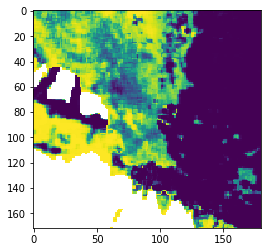

In [33]:
for folder in tqdm.tqdm(folders):
    try:
        image_name = os.path.basename(folder) + ".tiff"
        image_path = os.path.join(results_folder, 'bigger_' + image_name)
        if (not os.path.exists(image_path)) or True:
            mask = [f for f in masks if os.path.splitext(image_name)[0] in f][0]

            hh_image, hv_image, conc_image = read_data(folder)
            conc_image = cv.imread(os.path.join('masks',mask), cv.IMREAD_GRAYSCALE)
            if conc_image is None:
                print("BAAAD: ", folder)
                continue
        #         conc_image_big = np.zeros(hh_image.shape)
            conc_image_big = cv.resize(conc_image, hh_image.shape[0:2][::-1])
            conc = predict_image_fine(hh_image, hv_image, conc_image_big, net)*200
            image_name = os.path.basename(folder) + ".tiff"
            mask_name = 'new_mask_' + image_name
            image_path = os.path.join(results_folder, 'bigger_' + image_name)
            mask_path = os.path.join(results_folder, mask_name)
            cv.imwrite(image_path, conc)
            new_mask  = np.isnan(conc).astype(np.uint8)*255
            cv.imwrite(mask_path, new_mask)
            plt.imshow(conc)
        else:
            print("AD: " + image_name)
    except:
        print(folder)

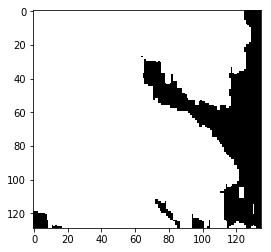

In [46]:
plt.imshow(cv.imread('masks/' + mask))

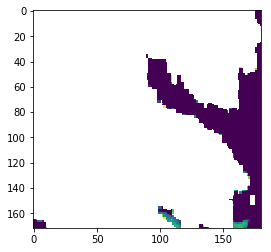

In [48]:
plt.imshow(conc)

In [ ]:
plt.imshow()

In [18]:
cv.imread()

TypeError: Required argument 'filename' (pos 1) not found

In [ ]:
new_mask

In [ ]:
new_mask.dtype

In [ ]:
plt.imshow(np.isnan(conc))

In [ ]:
np.nan

In [ ]:
new_mask.shape